In [49]:
from unmixing.utils import as_array
from unmixing.utils import pixel_to_xy
import pysptools.eea as sp_extract
%matplotlib inline
from unmixing.utils import array_to_raster, dump_raster
from unmixing.visualize import FeatureSpace
import numpy as np
from unmixing.transform import mnf_rotation

In [101]:
image, gt, wkt = as_array('C:/Users/Henrike/SoftwareDev_Final/test.tif')
image

(5, 3689, 6414)

In [123]:
file = 'C:/Users/Henrike/SoftwareDev_Final/test.tif'
img = gdal.Open(file)
band = img.GetRasterBand(1)
band.GetNoDataValue()

0.0

In [126]:
img_na = np.any(image == 0.0, axis = 0)
img_na

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [124]:
image_masked = np.ma.MaskedArray(image, img_na, fill_value = 0.0)
image_masked

MaskError: Mask and data not compatible: data size is 118306230, mask size is 23661246.

In [73]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [74]:
scaled_image = NormalizeData(image)
scaled_image

array([[[0.04394598, 0.04411383, 0.04238956, ..., 0.16816968,
         0.21147478, 0.2396582 ],
        [0.04269474, 0.04162661, 0.04217594, ..., 0.11705196,
         0.12870985, 0.13002213],
        [0.04345769, 0.04164187, 0.04716564, ..., 0.09658961,
         0.09527733, 0.09706264],
        ...,
        [0.08632029, 0.0802472 , 0.07731746, ..., 0.22272068,
         0.21756313, 0.26164645],
        [0.0792401 , 0.07533379, 0.07624933, ..., 0.23016709,
         0.2399176 , 0.26775006],
        [0.07615778, 0.06651408, 0.06764324, ..., 0.26845197,
         0.27241932, 0.3042649 ]],

       [[0.05212482, 0.05325399, 0.05458152, ..., 0.12607004,
         0.23413443, 0.26997787],
        [0.05322347, 0.05499351, 0.05595483, ..., 0.06059358,
         0.07722591, 0.08183413],
        [0.05011063, 0.05111772, 0.0568246 , ..., 0.04509041,
         0.04176394, 0.04213016],
        ...,
        [0.19056992, 0.20550851, 0.18698405, ..., 0.22232395,
         0.22360571, 0.23553826],
        [0.1

In [79]:
# Calculate NDVI
red = scaled_image[2]
red
nir = scaled_image[4]
nir

array([[0.09381247, 0.08899062, 0.08569467, ..., 0.24640269, 0.29211872,
        0.32452888],
       [0.09005875, 0.09308003, 0.09266804, ..., 0.17389181, 0.18326085,
        0.19491875],
       [0.07827878, 0.07096971, 0.09262226, ..., 0.13731594, 0.12584115,
        0.12843519],
       ...,
       [0.53244831, 0.5534905 , 0.57880522, ..., 0.39877928, 0.40653086,
        0.42880903],
       [0.56588083, 0.56226444, 0.57476158, ..., 0.41593042, 0.42529946,
        0.43767453],
       [0.55225452, 0.53861295, 0.55208667, ..., 0.41037613, 0.44164187,
        0.46291295]])

In [80]:
ndvi = (nir - red) / (nir + red)
ndvi.shape

C:\Users\Henrike\AppData\Local\Temp\ipykernel_10664\1441289170.py:1: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)


(3689, 6414)

In [50]:
ppi = sp_extract.PPI()

# Extract 3 endmembers using the PPI algorithm with 2,000 random projections
members = ppi.extract(scaled_image[...,0:3], 10, numSkewers = 1000)
members

array([[0.7977569 , 0.8960555 , 0.9897612 ],
       [0.84682995, 0.8870222 , 0.93302816],
       [0.8813306 , 0.828809  , 0.7384909 ],
       [0.2509346 , 0.27235827, 0.2876478 ],
       [0.18284886, 0.18767071, 0.19357595],
       [0.19285877, 0.2087129 , 0.20956741],
       [0.20662242, 0.21324483, 0.21715114],
       [0.20935377, 0.22154574, 0.23796445],
       [0.2280003 , 0.2286717 , 0.24429694],
       [0.24951553, 0.24686046, 0.2643015 ]], dtype=float32)

In [51]:
ppi.get_idx()

# Switch pixel coordinates from (p, m, n) to (n, m, p)
coords = [(y, x) for x, y in ppi.get_idx()]

pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)

[(-3.862807314687129, -73.33802463014715),
 (-3.8628047823127516, -73.33802463507536),
 (-3.862813012529513, -73.33802461905866),
 (-3.8632251552217083, -73.3380231866412),
 (-3.8632213566601648, -73.33802319403432),
 (-3.8632219897537543, -73.33802319280213),
 (-3.8632226228473585, -73.33802319156995),
 (-3.863223255940945, -73.33802319033776),
 (-3.8632238890345327, -73.33802318910557),
 (-3.8632245221281214, -73.33802318787338)]

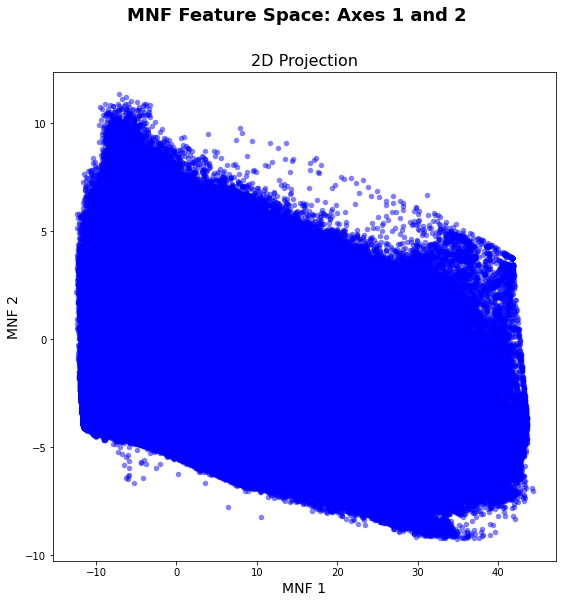

In [52]:
# Convert array to gdal.Dataset (raster), dump to file
dump_raster(array_to_raster(scaled_image, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_arrayImage.tiff', nodata = -9999)

# Set feature_limit = None so that we see every pixel, not a random subset
vis_fs = FeatureSpace(path = 'C:/Users/Henrike/SoftwareDev_Final/test_arrayImage.tiff', nodata = -9999,
                      feature_limit = None)
vis_fs.plot_feature_space()

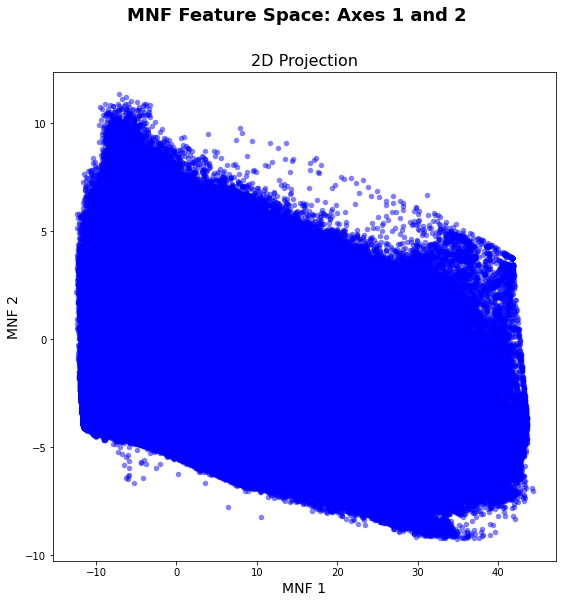

NameError: name 'plt' is not defined

In [53]:
%matplotlib inline
%config InlineBackend.close_figures=False
vis_fs.plot_feature_space()

from unmixing.utils import spectra_at_xy

# Get MNF spectra from the HSI cube using the lat-lon coordinates
lat_lon_coords = pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)
mnf_spectra = spectra_at_xy(scaled_image.T, lat_lon_coords, gt, wkt, dd = True)
vis_fs.plot_spectral_points(mnf_spectra)
plt.show()

In [48]:
fippi = sp_extract.FIPPI()

memberPPI = fippi.extract(scaled_image, q=3, maxit=10)
memberPPI

array([[0.45047686, 0.44336614, 0.45743495, ..., 0.06718548, 0.06015106,
        0.06034943],
       [0.07951476, 0.07438773, 0.06373694, ..., 0.07524224, 0.09752041,
        0.07734798],
       [0.10031281, 0.08740368, 0.08728161, ..., 0.23625544, 0.19679561,
        0.16678111],
       ...,
       [0.60694283, 0.6045014 , 0.61257344, ..., 0.19668879, 0.20140383,
        0.19896239],
       [0.63724726, 0.61678493, 0.59659725, ..., 0.25423056, 0.27377737,
        0.28514534],
       [0.63886476, 0.60367745, 0.5849241 , ..., 0.24695201, 0.26671246,
        0.27925536]], dtype=float32)